# Product Recommendation System - MovieLens (Analysis)

This notebook covers:
- Loading the MovieLens data
- Performing explanatory analysis (users, movies, sparsity)
- Time-based train/test split per user
- Baseline recommender: **Popularity-based Top-N**

In [19]:
import sys
from pathlib import Path

# Add the project root to the system path so that local module imports do not
# throw an exception
PROJECT_ROOT = Path('..').resolve()

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

In [20]:
import pandas as pd
import numpy as np

from pathlib import Path

# Local imports
from src.data import load_movielens, time_based_split

In [26]:
DATA_DIR = Path('..') / 'data' # Expects `../data/ratings.csv` and `../data/movies.csv`

ratings, movies = load_movielens(DATA_DIR)

print('Ratings')
print(ratings.head())

print('\nMovies')
print(movies.head())

Ratings
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Movies
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


## Basic Dataset Stats

In [4]:
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
num_ratings = len(ratings)

density = num_ratings / (num_users * num_movies)

print(f'Users: {num_users:,}')
print(f'Movies: {num_movies:,}')
print(f'Ratings: {num_ratings:,}')
print(f'Matrix density (ratings/(users*movies)): {density}')

Users: 610
Movies: 9,724
Ratings: 100,836
Matrix density (ratings/(users*movies)): 0.016999683055613623


## Rating Distribution

In [5]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

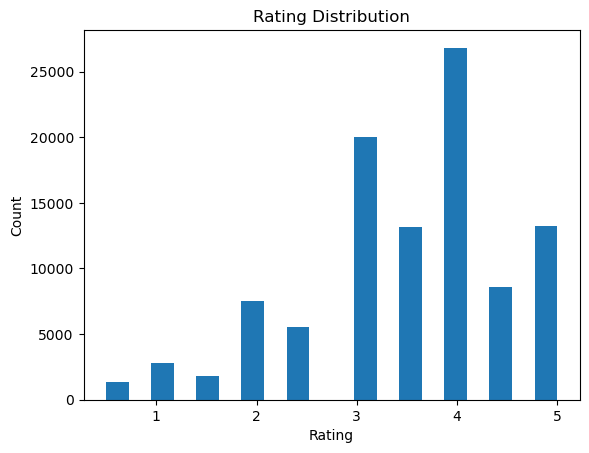

In [6]:
# Optional: Quick histogram
import matplotlib.pyplot as plt

plt.figure()
plt.hist(ratings['rating'], bins = 20)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

## Time-Based Split (Per User)

We split per user to aboid leakage
- Train = earlier interactions
- Test = most recent interactions

In [7]:
train, test = time_based_split(
    ratings,
    test_ratio = 0.2,
    min_ratings_per_user = 5
)

print(f'Train ratings: {len(train)}')
print(f'Test ratings: {len(test)}')
print(f'Train users: {train['userId'].nunique()}')
print(f'Test users: {test['userId'].nunique()}')

Train ratings: 80672
Test ratings: 20164
Train users: 610
Test users: 610


## Baseline: Popularity Recommender

Simple, strong baseline:
- Recommend movies with the most ratings in the **training set**
- Optional: enforce a minimum number of ratings so that we avoid one-rating wonders
  

In [9]:
def build_popularity_ranking(
    train_df: pd.DataFrame,
    min_ratings: int = 50
) -> pd.DataFrame:
    '''
    Returns a Dataframe with columns:
    movieId, rating_count, rating_mean
    sorted by rating_count desc then rating_mean desc
    '''
    agg = (
        train_df.groupby('movieId')['rating']
        .agg(rating_count = 'count', rating_mean = 'mean')
        .reset_index()
    )

    agg = agg[agg['rating_count'] >= min_ratings].copy()
    agg.sort_values(['rating_count', 'rating_mean'], ascending = [False, False], inplace = True)

    return agg

pop_rank = build_popularity_ranking(train, min_ratings = 50)
pop_rank.head()

,movieId,rating_count,rating_mean
302,356,304,4.156250
266,318,281,4.416370
247,296,271,4.175277
1865,2571,260,4.196154
490,593,253,4.169960


In [11]:
# Join titles for readability

pop_with_titles = pop_rank.merge(movies[['movieId', 'title']], on = 'movieId', how = 'left')
pop_with_titles.head(15)

,movieId,rating_count,rating_mean,title
0,356,304,4.156250,Forrest Gump (1994)
1,318,281,4.416370,"Shawshank Redemption, The (1994)"
2,296,271,4.175277,Pulp Fiction (1994)
3,2571,260,4.196154,"Matrix, The (1999)"
4,593,253,4.169960,"Silence of the Lambs, The (1991)"
5,260,237,4.223629,Star Wars: Episode IV - A New Hope (1977)
6,110,225,4.020000,Braveheart (1995)
7,480,222,3.761261,Jurassic Park (1993)
8,1,201,3.915423,Toy Story (1995)
9,589,200,3.945000,Terminator 2: Judgment Day (1991)


## Baseline recommender function (Top-K)

For each user:
- Recommend the top-K popular movies
- Exclude movies the user has already rated in training

In [15]:
def recommend_popularity_for_user(
    user_id: int,
    train_df: pd.DataFrame,
    pop_rank_df: pd.DataFrame,
    k: int = 10
) -> list[int]:
    seen = set(train_df.loc[train_df['userId'] == user_id, 'movieId'].tolist())
    recommended = []

    for mid in pop_rank_df['movieId'].tolist():
        if mid not in seen:
            recommended.append(int(mid))

        if len(recommended) >= k:
            break

    return recommended

# Quick sanity check on a random user
sample_user = int(train['userId'].sample(1, random_state = 42).iloc[0])
recommended = recommend_popularity_for_user(sample_user, train, pop_rank, k = 10)
movies[movies['movieId'].isin(recommended)][['movieId', 'title']]

,movieId,title
46,50,"Usual Suspects, The (1995)"
97,110,Braveheart (1995)
337,380,True Lies (1994)
461,527,Schindler's List (1993)
508,590,Dances with Wolves (1990)
509,592,Batman (1989)
520,608,Fargo (1996)
659,858,"Godfather, The (1972)"
2226,2959,Fight Club (1999)
2674,3578,Gladiator (2000)


## Prepare test relevance mapping

For evaluation later, we create
- user -> list of relevant `movieId` (from test)

In [18]:
user_to_test_movies = (
    test.groupby('userId')['movieId']
    .apply(lambda s: [int(x) for x in s.tolist()])
    .to_dict()
)

len(user_to_test_movies), list(user_to_test_movies.items())[:1]

(610,
 [(1,
   [1219,
    1348,
    2644,
    2654,
    1258,
    1278,
    2459,
    2648,
    2716,
    2657,
    1092,
    3386,
    1625,
    3176,
    1644,
    3273,
    2338,
    1265,
    943,
    1226,
    163,
    2291,
    1270,
    1240,
    1206,
    3702,
    3033,
    593,
    47,
    2353,
    3147,
    527,
    5060,
    1090,
    1224,
    151,
    3448,
    780,
    1298,
    3053,
    157,
    1445,
    553,
    2478,
    2012,
    2492])])

## Next Steps

- Implement **item-based collaboration filtering** in `filtering.ipynb`
- Compare baseline vs filtering in `evaluation.ipynb`